## BC2GM-IOB [EMBO-BLURB] Dataset: Monolingual Named Entity Recognition

Dataset Source: https://huggingface.co/datasets/EMBO/BLURB

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset

import torch
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import peft
from peft import get_peft_config, PeftModel, PeftConfig
from peft import get_peft_model, LoraConfig, TaskType

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)
print("PEFT :".rjust(18), peft.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
          Pandas : 2.0.3
           Torch : 2.0.1
    Transformers : 4.26.1
        Datasets : 2.13.1
        Evaluate : 0.4.0
         Sklearn : 1.3.0
            PEFT : 0.3.0


#### Ingest Dataset

In [3]:
ds = load_dataset("EMBO/SourceData")

ds = ds.remove_columns(['tag_mask', 'text'])

ds = ds.rename_columns(
    {
        "words": "tokens",
        "labels": "tags"})

ds

Found cached dataset source_data (/Users/briandunn/.cache/huggingface/datasets/EMBO___source_data/NER/0.0.0/7898ea3b9a5c23a2cf35c5bac8353dfa312569800a92b13b4035de62ba832a15)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 55250
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 6844
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 7951
    })
})

#### Example

In [4]:
example = ds['train'][12]

example

{'tokens': ['B',
  '.',
  'Proteins',
  'extracted',
  'from',
  'transgenic',
  'plants',
  'expressing',
  'YFP',
  '-',
  'CPL1',
  'in',
  'Col',
  '-',
  '0',
  'or',
  'free1',
  '-',
  'ctmut',
  'background',
  'were',
  'used',
  'for',
  'IP',
  'with',
  'GFP',
  '-',
  'trap',
  'followed',
  'by',
  'immunoblotting',
  'analysis',
  'with',
  'indicated',
  'antibodies',
  '.'],
 'tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  13,
  0,
  3,
  0,
  0,
  0,
  0,
  13,
  0,
  0,
  0,
  0,
  0]}

#### Display Feature Information About Each Feature

In [5]:
for k, v in ds["train"].features.items():
    print(f"{k}: \n{v}\n")

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

tags: 
Sequence(feature=ClassLabel(names=['O', 'B-SMALL_MOLECULE', 'I-SMALL_MOLECULE', 'B-GENEPROD', 'I-GENEPROD', 'B-SUBCELLULAR', 'I-SUBCELLULAR', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-TISSUE', 'I-TISSUE', 'B-ORGANISM', 'I-ORGANISM', 'B-EXP_ASSAY', 'I-EXP_ASSAY', 'B-DISEASE', 'I-DISEASE', 'B-CELL_LINE', 'I-CELL_LINE'], id=None), length=-1, id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [6]:
tag_values = ds['train'].features[f'tags'].feature.names
NUM_OF_LABELS = len(tag_values)

label2id = {tag: idx for idx, tag in enumerate(tag_values)}
id2label = {idx: tag for idx, tag in enumerate(tag_values)}

print(f"List of tag values: \n{tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['O', 'B-SMALL_MOLECULE', 'I-SMALL_MOLECULE', 'B-GENEPROD', 'I-GENEPROD', 'B-SUBCELLULAR', 'I-SUBCELLULAR', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-TISSUE', 'I-TISSUE', 'B-ORGANISM', 'I-ORGANISM', 'B-EXP_ASSAY', 'I-EXP_ASSAY', 'B-DISEASE', 'I-DISEASE', 'B-CELL_LINE', 'I-CELL_LINE']
Number of NER Tags: 
19
id2label: 
{0: 'O', 1: 'B-SMALL_MOLECULE', 2: 'I-SMALL_MOLECULE', 3: 'B-GENEPROD', 4: 'I-GENEPROD', 5: 'B-SUBCELLULAR', 6: 'I-SUBCELLULAR', 7: 'B-CELL_TYPE', 8: 'I-CELL_TYPE', 9: 'B-TISSUE', 10: 'I-TISSUE', 11: 'B-ORGANISM', 12: 'I-ORGANISM', 13: 'B-EXP_ASSAY', 14: 'I-EXP_ASSAY', 15: 'B-DISEASE', 16: 'I-DISEASE', 17: 'B-CELL_LINE', 18: 'I-CELL_LINE'}
label2id: 
{'O': 0, 'B-SMALL_MOLECULE': 1, 'I-SMALL_MOLECULE': 2, 'B-GENEPROD': 3, 'I-GENEPROD': 4, 'B-SUBCELLULAR': 5, 'I-SUBCELLULAR': 6, 'B-CELL_TYPE': 7, 'I-CELL_TYPE': 8, 'B-TISSUE': 9, 'I-TISSUE': 10, 'B-ORGANISM': 11, 'I-ORGANISM': 12, 'B-EXP_ASSAY': 13, 'I-EXP_ASSAY': 14, 'B-DISEASE': 15, 'I-DISEASE': 16, 'B-CELL_LIN

#### Basic Values/Constants

In [7]:
MODEL_CKPT = "bert-large-cased"

MODEL_NAME = f"{MODEL_CKPT}-lora-finetuned-ner-EMBO-SourceData"
NUM_OF_EPOCHS = 3

BATCH_SIZE = 16
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

LR = 1e-3
DEVICE = torch.device("cpu")

STEPS = 300

#### Function to Tokenize & Align Inputs

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          add_prefix_space=True)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"], 
                                      truncation=True, 
                                      is_split_into_words=True)
    
    labels = []
    
    for idx, label in enumerate(samples[f"tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [9]:
encoded_ds = ds.map(tokenize_and_align_labels, 
                       batched=True, 
                       remove_columns=
                        [
                            'tags', 
                            'tokens'
                        ]
                    )

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/EMBO___source_data/NER/0.0.0/7898ea3b9a5c23a2cf35c5bac8353dfa312569800a92b13b4035de62ba832a15/cache-2a6ce67ccd9a0ebc.arrow


Map:   0%|          | 0/6844 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/EMBO___source_data/NER/0.0.0/7898ea3b9a5c23a2cf35c5bac8353dfa312569800a92b13b4035de62ba832a15/cache-1118e1e99952c21d.arrow


#### Define Data Collator

In [10]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [11]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-c

#### Create Compute Metrics Function

In [12]:
seqeval = evaluate.load("seqeval")

labels = [tag_values[i] for i in example[f'tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [tag_values[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [tag_values[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    seqeval_results = seqeval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    results = {
        "precision": seqeval_results["overall_precision"],
        "recall": seqeval_results["overall_recall"],
        "f1": seqeval_results["overall_f1"],
        "accuracy": seqeval_results["overall_accuracy"]}
    
    return results

#### Define Function to Display Parameter Information

In [13]:
# Define Helper Function to Check Total Number of Model Parameters
# Also, return Number of Trainable Parameters

def print_parameters_information(model):
    trainable_parameters = 0
    all_parameters = 0
    
    for _, parameters in model.named_parameters():
        all_parameters += parameters.numel()
        if parameters.requires_grad:
            trainable_parameters += parameters.numel()
    
    print(f'Trainable Parameters: {trainable_parameters} ' + \
          f'|| All Parameters: {all_parameters} ' + \
          f'|| Trainable %: {round(trainable_parameters / all_parameters * 100, 2)}')

#### Define LoraConfig

In [14]:
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, 
    inference_mode=False, 
    r=16, 
    lora_alpha=16, 
    lora_dropout=0.1, 
    bias="all"
)

#### Update Model With LoraConfiguration

In [15]:
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 1883174 || all params: 334141478 || trainable%: 0.5635858233679089


#### Define TrainingArguments

In [16]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    use_mps_device=False,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    group_by_length=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [17]:
trainer = Trainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

Cloning https://huggingface.co/DunnBC22/bert-large-cased-lora-finetuned-ner-EMBO-SourceData into local empty directory.


#### Train Model

In [18]:
train_results = trainer.train()

/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10362 [00:00<?, ?it/s]

{'loss': 3.3243, 'learning_rate': 0.0009999034935340668, 'epoch': 0.0}
{'loss': 0.3091, 'learning_rate': 0.0009710480602200348, 'epoch': 0.09}
{'loss': 0.2062, 'learning_rate': 0.0009420961204400695, 'epoch': 0.17}
{'loss': 0.1979, 'learning_rate': 0.0009131441806601043, 'epoch': 0.26}
{'loss': 0.1799, 'learning_rate': 0.000884192240880139, 'epoch': 0.35}
{'loss': 0.1762, 'learning_rate': 0.0008552403011001737, 'epoch': 0.43}
{'loss': 0.1701, 'learning_rate': 0.0008262883613202085, 'epoch': 0.52}
{'loss': 0.1618, 'learning_rate': 0.0007973364215402432, 'epoch': 0.61}
{'loss': 0.1582, 'learning_rate': 0.0007683844817602779, 'epoch': 0.69}
{'loss': 0.1535, 'learning_rate': 0.0007394325419803128, 'epoch': 0.78}
{'loss': 0.1507, 'learning_rate': 0.0007104806022003475, 'epoch': 0.87}
{'loss': 0.1552, 'learning_rate': 0.0006815286624203821, 'epoch': 0.96}


  0%|          | 0/428 [00:00<?, ?it/s]

{'eval_loss': 0.14989228546619415, 'eval_precision': 0.7568749905718725, 'eval_recall': 0.7968047769537392, 'eval_f1': 0.7763267832276033, 'eval_accuracy': 0.9516311809444941, 'eval_runtime': 6640.1606, 'eval_samples_per_second': 1.031, 'eval_steps_per_second': 0.064, 'epoch': 1.0}
{'loss': 0.1394, 'learning_rate': 0.0006525767226404169, 'epoch': 1.04}
{'loss': 0.1346, 'learning_rate': 0.0006236247828604516, 'epoch': 1.13}
{'loss': 0.1366, 'learning_rate': 0.0005946728430804864, 'epoch': 1.22}
{'loss': 0.1317, 'learning_rate': 0.0005657209033005212, 'epoch': 1.3}
{'loss': 0.1336, 'learning_rate': 0.000536768963520556, 'epoch': 1.39}
{'loss': 0.1281, 'learning_rate': 0.0005078170237405906, 'epoch': 1.48}
{'loss': 0.1262, 'learning_rate': 0.0004788650839606254, 'epoch': 1.56}
{'loss': 0.1246, 'learning_rate': 0.0004499131441806601, 'epoch': 1.65}
{'loss': 0.1233, 'learning_rate': 0.00042096120440069485, 'epoch': 1.74}
{'loss': 0.1217, 'learning_rate': 0.0003920092646207296, 'epoch': 1.82

  0%|          | 0/428 [00:00<?, ?it/s]

{'eval_loss': 0.13277916610240936, 'eval_precision': 0.7909505762239926, 'eval_recall': 0.812002731502803, 'eval_f1': 0.8013384111461125, 'eval_accuracy': 0.9563729015480056, 'eval_runtime': 6092.2011, 'eval_samples_per_second': 1.123, 'eval_steps_per_second': 0.07, 'epoch': 2.0}
{'loss': 0.1076, 'learning_rate': 0.0003051534452808338, 'epoch': 2.08}
{'loss': 0.1093, 'learning_rate': 0.0002762015055008686, 'epoch': 2.17}
{'loss': 0.105, 'learning_rate': 0.00024724956572090334, 'epoch': 2.26}
{'loss': 0.1068, 'learning_rate': 0.00021829762594093805, 'epoch': 2.35}
{'loss': 0.1027, 'learning_rate': 0.0001893456861609728, 'epoch': 2.43}
{'loss': 0.1021, 'learning_rate': 0.00016039374638100753, 'epoch': 2.52}
{'loss': 0.1015, 'learning_rate': 0.00013144180660104227, 'epoch': 2.61}
{'loss': 0.1003, 'learning_rate': 0.00010248986682107701, 'epoch': 2.69}
{'loss': 0.0998, 'learning_rate': 7.353792704111176e-05, 'epoch': 2.78}
{'loss': 0.0996, 'learning_rate': 4.458598726114649e-05, 'epoch': 2

  0%|          | 0/428 [00:00<?, ?it/s]

{'eval_loss': 0.1281939446926117, 'eval_precision': 0.7998649706157647, 'eval_recall': 0.827835919261859, 'eval_f1': 0.8136101139378804, 'eval_accuracy': 0.9583887230224973, 'eval_runtime': 6122.247, 'eval_samples_per_second': 1.118, 'eval_steps_per_second': 0.07, 'epoch': 3.0}
{'train_runtime': 187844.0713, 'train_samples_per_second': 0.882, 'train_steps_per_second': 0.055, 'train_loss': 0.13774657309273913, 'epoch': 3.0}


#### Push Model To Hub

In [19]:
kwargs = {
    "tasks": "token-classification",
    "tags": ['token-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.25G [00:00<?, ?B/s]

Upload file runs/Jul18_23-31-30_Brians-Mac-mini.local/events.out.tfevents.1689741106.Brians-Mac-mini.local.630…

To https://huggingface.co/DunnBC22/bert-large-cased-lora-finetuned-ner-EMBO-SourceData
   5361bb3..64b0b95  main -> main

To https://huggingface.co/DunnBC22/bert-large-cased-lora-finetuned-ner-EMBO-SourceData
   64b0b95..acfda51  main -> main



#### Save & Log Model

In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-large-cased-lora-finetuned-ner-EMBO-SourceData
   acfda51..7ebbf6c  main -> main



***** train metrics *****
  epoch                    =                3.0
  train_loss               =             0.1377
  train_runtime            = 2 days, 4:10:44.07
  train_samples_per_second =              0.882
  train_steps_per_second   =              0.055


### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [21]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, 
                               attention_mask
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 19), 
                         labels.view(-1), 
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [23]:
eval_set = encoded_ds['validation']

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7f80ecc72ee0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/7951 [00:00<?, ? examples/s]

#### Clean Up Padding Tokens

In [24]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 170, 117, 27524, 10294, 2116, 1104, 4098...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, IGN, IGN, O, O, O, O, O, O, O, ...","[0.0, 0.00011801023, 1.5616295e-05, 4.768258e-...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-G...","[[CLS], a, ,, Det, ##ec, ##tion, of, wild, -, ..."


#### Unwrap Each Token Within Sample Separately

In [25]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,170,0,1,O,0.0,O,a
0,117,0,1,O,0.0,O,","
0,27524,0,1,O,0.0,O,Det
0,1104,0,1,O,0.0,O,of
0,4098,0,1,O,0.0,O,wild
0,118,0,1,O,0.0,O,-
0,2076,0,1,O,0.0,O,type


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [26]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Remove multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,-,T,N,P,p,L,H,R,G,D
count,26326,2325,2130,4438,4956,1745,2765,1379,3511,2808
mean,0.172,0.635,0.534,0.247,0.195,0.552,0.317,0.615,0.22,0.252
sum,4522.2,1476.06,1138.11,1096.46,966.95,963.51,877.63,848.47,771.43,706.53


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [27]:
(
    eval_df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
labels,I-DISEASE,B-DISEASE,I-SUBCELLULAR,I-TISSUE,B-CELL_TYPE,I-ORGANISM,B-TISSUE,I-CELL_TYPE,B-EXP_ASSAY,I-SMALL_MOLECULE,I-EXP_ASSAY,B-SUBCELLULAR,B-SMALL_MOLECULE,I-GENEPROD,I-CELL_LINE,B-ORGANISM,B-GENEPROD,B-CELL_LINE,O
count,218,633,905,977,2829,1555,3796,826,13096,2688,8486,3901,7896,6813,1458,4959,28251,3090,516883
mean,2.207,1.365,1.313,0.865,0.745,0.721,0.7,0.681,0.673,0.66,0.656,0.649,0.597,0.593,0.356,0.341,0.225,0.212,0.057
sum,481.15,864.05,1188.65,844.69,2107.28,1121.27,2655.66,562.18,8808.31,1774.31,5570.21,2529.93,4714.11,4043.17,519.58,1692.05,6345.88,656.26,29272.24


#### Create Function to Display Confusion Matrix

In [70]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.xticks(rotation = 60)
    plt.show()
    

#### Display Confusion Matrix

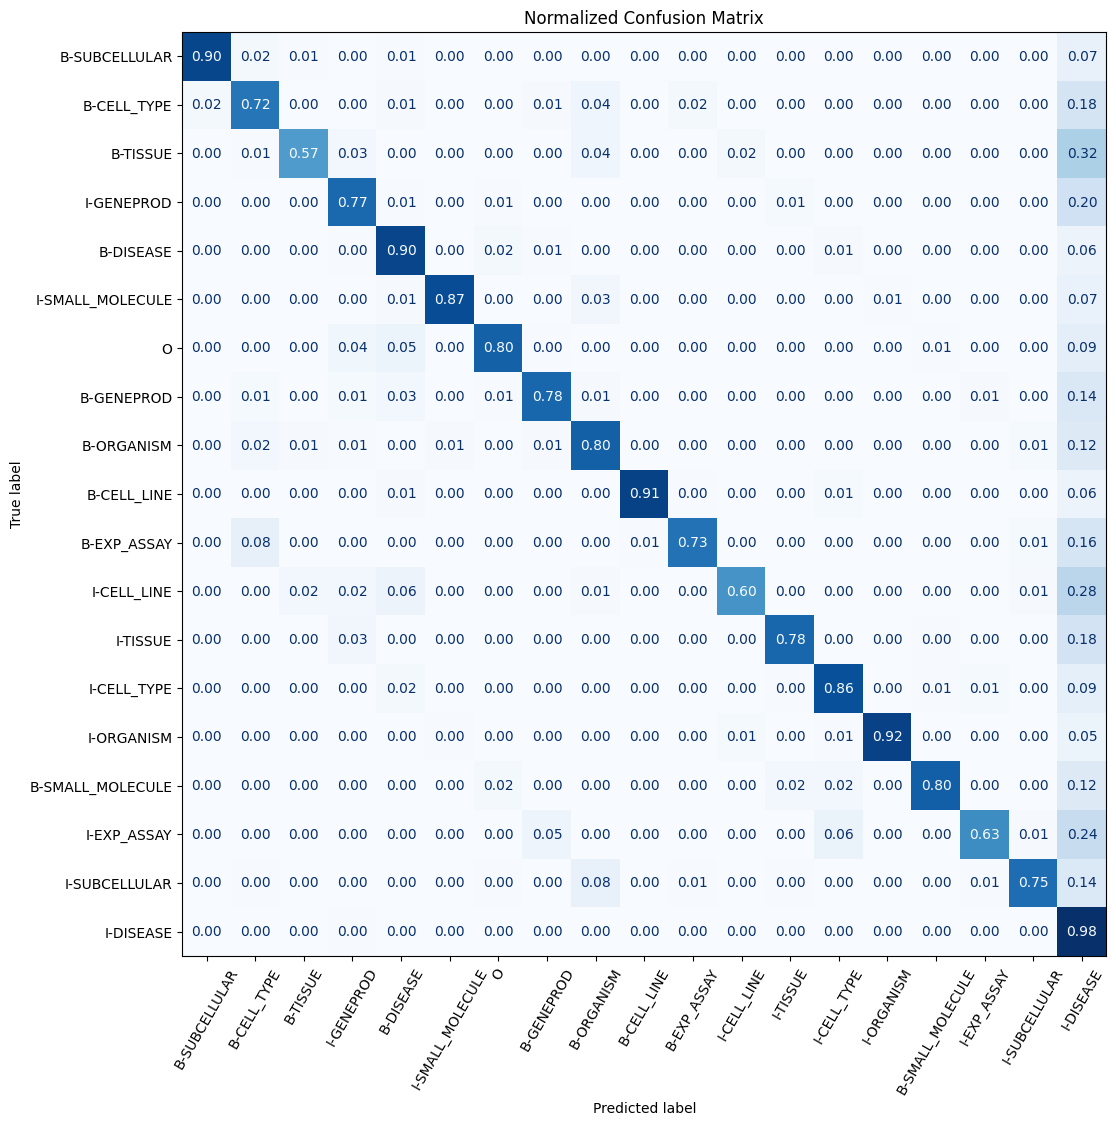

In [71]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

### Notes & Other Takeaways From This Project

****
- While this model is an improvement over the model trained using the BERT-Base checkpoint without LoRA/PEFT, the biggest takeaways is that the model struggled to correctly identify the Beginning of text chunks.

****

### Citations

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset

    >  @article{article, author = {Smith, Larry and Tanabe, Lorraine and Ando, Rie and Kuo, Cheng-Ju and Chung, I-Fang and Hsu, Chun-Nan and Lin, Yu-Shi and Klinger, Roman and Friedrich, Christoph and Ganchev, Kuzman and Torii, Manabu and Liu, Hongfang and Haddow, Barry and Struble, Craig and Povinelli, Richard and Vlachos, Andreas and Baumgartner Jr, William and Hunter, Lawrence and Carpenter, Bob and Wilbur, W.}, year = {2008}, month = {09}, pages = {S2}, title = {Overview of BioCreative II gene mention recognition}, volume = {9 Suppl 2}, journal = {Genome biology}, doi = {10.1186/gb-2008-9-s2-s2}}

- Metric (SeqEval)

    > @inproceedings{ramshaw-marcus-1995-text, title = "Text Chunking using Transformation-Based Learning", author = "Ramshaw, Lance and Marcus, Mitch", booktitle = "Third Workshop on Very Large Corpora", year = "1995", url = "https://www.aclweb.org/anthology/W95-0107",}
    
    > @misc{seqeval, title={{seqeval}: A Python framework for sequence labeling evaluation}, url={https://github.com/chakki-works/seqeval}, note={Software available from https://github.com/chakki-works/seqeval}, author={Hiroki Nakayama}, year={2018},}